# Estimar número de leitos necessários de enfermaria e UTI a cada momento

É desejável incluir no modelo uma previsão de necessidade de leitos de UTI e leitos de internação necessários ao atendimento de infectados pelo SARS-CoV2.


## Avaliação preliminar - nao validada

* numero de leitos ocupados em cada data = `total de casos ate a data` - `total de internacoes liberadas`

* total de casos ate a data = `casos acumulados ate a data` * `taxa de internacao ou uti`

* total de internacoes liberadas = `total de internacoes ate a "data critica"`

* data critica = `data em questao` - `estadia media` - `delay de ocupacao` (tipo tempo para limpar o leito) 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

In [164]:
sp= pd.read_csv('../data/csv/by_uf/SP.csv', parse_dates=['date']).drop_duplicates('date').set_index('date')

In [165]:
def compute_hospitalization_demand(daily_cases, average_stay,
                                   hospitalization_fraction=0.5, icu_fraction=0.5,
                                   occupancy_delay=6):
    """
    Params:
        daily_cases (pandas.DataFrame): df com `date` como index e uma coluna `cases` com registro de casos cumulativos.
        average_stay (int/fload): estadia média em dias.
        occupancy_delay (int/float): tempo em horas entre saída de um paciente e internação de outro.
    Returns:
        daily_cases: DataFrame com colunas `Internação` e `Tratamento Intensivo` para cada data.
    """
    
    if not isinstance(daily_cases, pd.DataFrame):
        msg = "daily_cases should be pandas.DataFrame with data as index and a 'cases' column with new cases at that day."
        raise TypeError(msg)
        
    average_stay = pd.Timedelta(f'{average_stay}d')
    occupancy_delay = pd.Timedelta(f'{6}h')
   
    hospitalization_beds, icu_beds, cum_released_beds_normal, cum_released_beds_icu = {}, {}, {}, {}
    previous_day = None
    
    for date in daily_cases.index:
        
        cumulative_hospitalization = (daily_cases.loc[date]['cases'] * hospitalization_fraction).round()
        cumulative_icu = (daily_cases.loc[date]['cases'] * icu_fraction).round()
        # to release a bed on `date`, patient must have checked in no later than `critical_checkin_date`
        critical_checkin_date = date - average_stay - occupancy_delay
        # entries for days up to critical check-in date:
        critical_checkin_ix = daily_cases.index <= critical_checkin_date 
        
        if any(critical_checkin_ix):
            # critical check-in date with valid entry in the provided dataframe
            critical_checkin_date =  daily_cases.index[critical_checkin_ix][-1]
            # total hosp. cases up to critical check-in date
            released_beds_normal = hospitalization_beds[critical_checkin_date]
            released_beds_icu = icu_beds[critical_checkin_date]
        else :
            released_beds_normal = 0
            released_beds_icu = 0
            
        if previous_day is not None and 'deaths' in daily_cases.columns:
            deaths_on_previous_day = daily_cases.loc[previous_day]['deaths']
            released_beds_normal += deaths_on_previous_day
            released_beds_icu += deaths_on_previous_day
            
        hospitalization_beds[date] = cumulative_hospitalization - released_beds_normal
        icu_beds[date] = cumulative_icu - released_beds_icu
        cum_released_beds_normal[date] = released_beds_normal
        cum_released_beds_icu[date] = released_beds_icu
        previous_day = date
        
    daily_cases['cumulative_release_normal'] = pd.Series(cum_released_beds_normal)
    daily_cases['cumulative_release_icu'] = pd.Series(cum_released_beds_icu)
    daily_cases['hospitalized_patients'] = pd.Series(hospitalization_beds)
    daily_cases['icu_patients'] = pd.Series(icu_beds)

    return daily_cases


### vamos usar taxa de internação de 0.5 e de UTI de 0.25, só para testar (provavel que fiquem ~0.2 e ~0.05, respectivamente)

* __Pacientes Internados__: round(casos acumulados * taxa de hosp.) - pacientes liberados - baixas por falecimento
* __Pacientes em Tratamento Intensivo__: round(casos acumulados * taxa de UTI) - pacientes liberados - baixas por falecimento

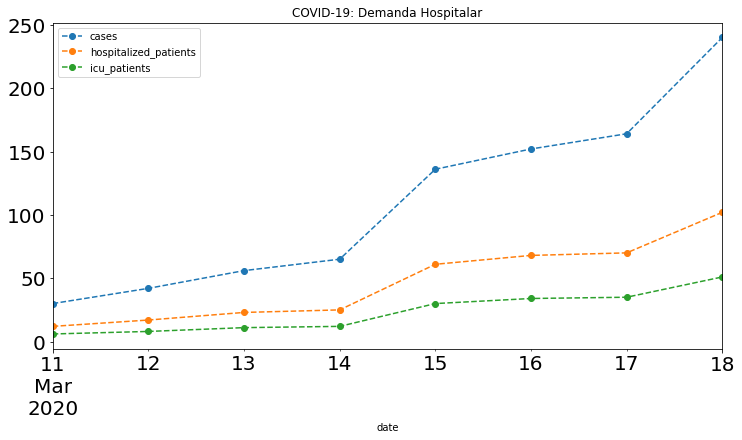

In [166]:
beds = compute_hospitalization_demand(
    daily_cases=sp, 
    average_stay=5,
    hospitalization_fraction=0.5,
    icu_fraction=0.25,
    occupancy_delay=5
)
beds[35:]

cols_to_plot = ['cases', 'hospitalized_patients', 'icu_patients']

beds[40:][cols_to_plot].plot(
    style='o--', figsize=(12,6), fontsize=20, title='COVID-19: Demanda Hospitalar'
)

## Projeção simples com taxa de crescimento constante

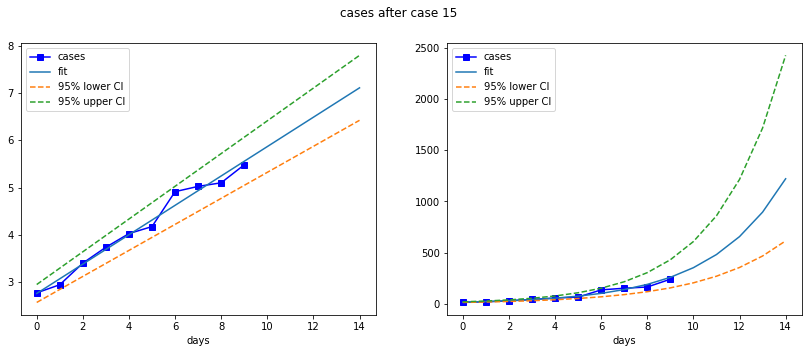

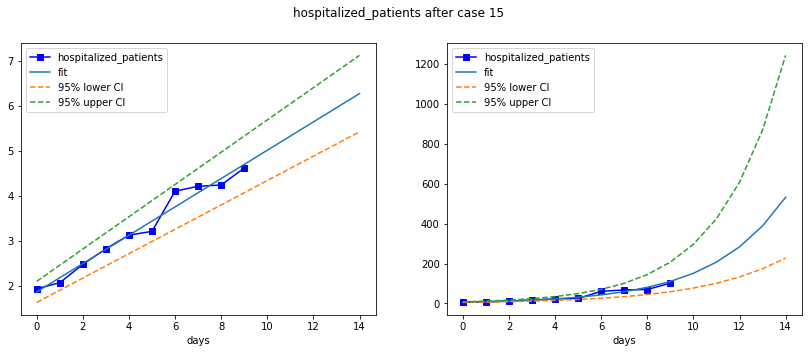

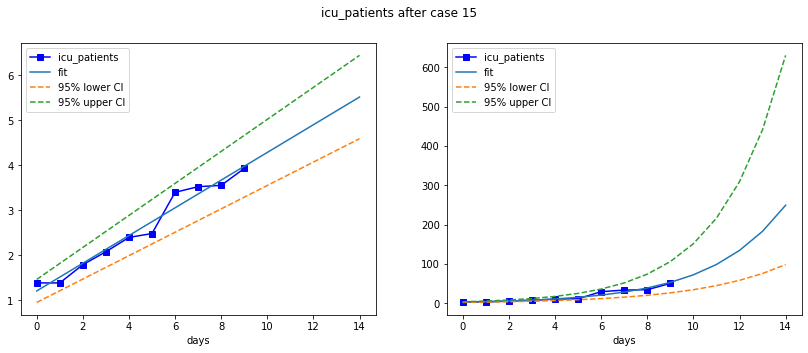

In [167]:
def plot_lm(y, yname, title, days_ahead=5, scale=None):
    if scale is None:
        scale = ['linear', 'exp']
    if not isinstance(scale, list):
        scale = [scale]
        
    model_matrix = np.array([[1, i] for i in range(len(y))])
    model = sm.OLS(y, model_matrix)
    results = model.fit()
    ci = results.conf_int().transpose()
    
    days_to_plot = range(len(y) + days_ahead)
    X_to_plot = np.array([[1, i] for i in days_to_plot])
    y_to_plot = [y[i] if i < len(y) else np.NaN for i in days_to_plot]

    res_df = pd.DataFrame({
          f'{yname}': y_to_plot, 
          'fit': results.predict(X_to_plot),
          '95% lower CI': X_to_plot.dot(ci[0]),
          '95% upper CI': X_to_plot.dot(ci[1]),
          f'days': [i for i in days_to_plot]
         }).set_index(f'days')
    
    if len(scale) == 2:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
        fig.suptitle(title)
        res_df.plot(style=['bs-','-','--', '--'], ax=axes[0])
        res_df.apply(np.exp).plot(style=['bs-','-','--', '--'], ax=axes[1])
    elif len(scale) == 1:
        if scale[0] == 'linear':
            res_df.plot(style=['bs-','-','--', '--'], title=title)
        else:
            res_df.apply(np.exp).plot(style=['bs-','-','--', '--'], title=title)
    else:
        raise
    return

cases_threshold = 15

for response in cols_to_plot:
    y = beds.query(f'cases > {cases_threshold}')[response].values
    scale = ['linear']
    if np.nanmin(y) > 0.:
        y = np.log(y)
        scale = ['linear', 'exp']
    plot_lm(y=y, yname=response, scale=scale,
            title=f'{response} after case {cases_threshold}')     

In [195]:
import os
files = os.listdir('../data/csv/by_uf/')
data_dict = {}
for file in files:
    uf = file.split('.')[0]
    d = pd.read_csv(f'../data/csv/by_uf/{file}', parse_dates=['date'])[['date', 'cases']].set_index('date')
    data_dict[uf] = d
    
df = pd.concat(data_list)
states = list(set(df['uf'].values))
hosp = {}
for state in states:
    d = df[(df.uf == state)].copy()
    if d.shape[0] > 0:
        hosp[state] = compute_hospitalization_demand(
                daily_cases=d,
                hospitalization_fraction=0.5,
                average_stay=5,
                icu_fraction=0.25,
                occupancy_delay=0)
                   

df = pd.concat(hosp).reset_index().rename(columns={'level_0': 'uf'})
df.head()

,uf,date,cases,uf,cumulative_release_normal,cumulative_release_icu,hospitalized_patients,icu_patients
0,AC,2020-03-10,0,AC,0,0,0,0
1,AC,2020-03-11,0,AC,0,0,0,0
2,AC,2020-03-12,0,AC,0,0,0,0
3,AC,2020-03-13,0,AC,0,0,0,0
4,AC,2020-03-14,0,AC,0,0,0,0
